# Fitting A Segmented Rating Curve
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thodson-usgs/rating-function-uncertainty/blob/master/notebooks/segmented_power_law_demo.ipynb)  
This notebook demonstrates fitting a rating curve using a segmented power law.

The general form of the equation is:

\begin{align}
    log(Q) = a + \sum b_i\log(x - x_{o,i})H_i(x - x_{o,i})
\end{align}
where
$H$ is the Heaviside function,  
$x_{o,i}$ is the $i$th breakpoint


In [4]:
# Run this cell to setup Colab. It will take a minute.
%%capture
# Specific repo version used in this notebook
!pip install pymc==4.1.1

# Colab needs this
%env MKL_THREADING_LAYER=GNU

# install ratingcurve library
!pip install git+https://github.com/thodson-usgs/rating-function-uncertainty.git

UsageError: Line magic function `%%capture` not found.


In [1]:
# Run this cell when experimenting locally.
%load_ext autoreload
%autoreload 2

## Load Dataset

In [2]:
# load the data catalog
import intake
url = 'https://raw.githubusercontent.com/thodson-usgs/rating-function-uncertainty/main/data/rating_data_catalog.yml'
cat = intake.open_catalog(url)
list(cat)

['simulated_rating',
 'chalk_artificial',
 'provo_natural',
 'co_channel',
 'green_channel']

In [3]:
# load a dataset
df = cat['green_channel'].read()
df.head()

,datetime,stage,q,q_sigma
0,2020-05-21 14:13:41 [UTC-07:00],7.04,12199.342,199.172931
1,2020-04-16 14:55:31 [UTC-07:00],4.43,4921.953,95.425619
2,2020-03-04 13:54:10 [UTC-07:00],2.99,2331.665,61.860500
3,2020-03-04 13:16:51 [UTC-07:00],2.94,2289.220,47.886745
4,2020-01-23 11:04:32 [UTC-07:00],2.96,2408.210,99.522964


<AxesSubplot:xlabel='q', ylabel='stage'>

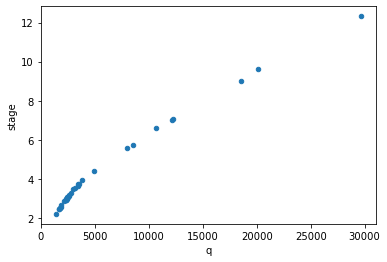

In [4]:
h_obs = df['stage'].values.reshape(-1,1)
q_obs = df['q'].values.reshape(-1,1)
q_sigma = df['q_sigma'].values.reshape(-1,1)

df.plot.scatter(x='q',y='stage', marker='o')

## Set model

In [7]:
from ratingcurve.ratingmodel import SegmentedRatingModel
import pymc

segments = 2
powerrating = SegmentedRatingModel(q_obs, h_obs,  segments=segments,
                                   #q_sigma = q_sigma, not working
                                   q_sigma = None,
                                   prior = {'distribution':'uniform'})

In [10]:
#mean_field = powerrating.fit()

Finished [100%]: Average Loss = 40.575


In [15]:
import pymc as pm

with powerrating:
    method = 'advi'
    mean_field = pm.fit(method=method, n=100_000)
    trace = mean_field.sample(5000)

Finished [100%]: Average Loss = -42.703


In [17]:
import arviz as az
az.summary(trace, var_names=["w","a","sigma","hs"])

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],1.184,0.006,1.173,1.195,0.000,0.0,5010.0,4708.0,NaN
w[1],0.450,0.008,0.437,0.466,0.000,0.0,4768.0,4569.0,NaN
a,-1.186,0.006,-1.197,-1.175,0.000,0.0,4952.0,5024.0,NaN
sigma,0.032,0.004,0.025,0.041,0.000,0.0,5077.0,4639.0,NaN
hs[0],1.242,0.009,1.226,1.260,0.000,0.0,5005.0,4481.0,NaN
hs[1],3.543,0.047,3.455,3.629,0.001,0.0,4578.0,4980.0,NaN


In [19]:

plot_power_law_rating(powerrating,  trace, None)

NameError: name 'plot_power_law_rating' is not defined

In [ ]:
# what happens if we choose a different number of segments?

# Synthetic Data

<AxesSubplot:xlabel='q', ylabel='stage'>

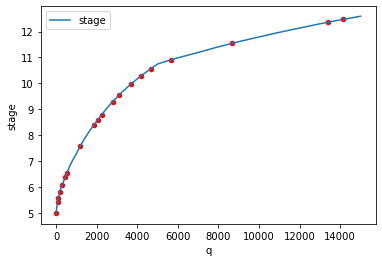

In [35]:
# load a dataset
n = 20
sim_df = cat['simulated_rating'].read()
df = sim_df.sample(n)
df = df.sort_values(by='q') #XXX sort or plotting goes crazy
#fig, ax = plt.subplots()
h_obs = df['stage'].values.reshape(-1,1)
q_obs = df['q'].values.reshape(-1,1)
ax = sim_df.plot(x='q',y='stage')
df.plot.scatter(x='q',y='stage', marker='o', color='red', ax=ax)

In [36]:
segments = 3
powerrating = SegmentedRatingModel(q_obs, h_obs,  segments=segments,
                                   #q_sigma = q_sigma,
                                   q_sigma = None,
                                   prior = {'distribution':'uniform'})


In [37]:
with powerrating:
    method = 'advi'
    mean_field = pm.fit(method=method, n=200_000)
    trace = mean_field.sample(5000)

Finished [100%]: Average Loss = -18.956


In [38]:
# advi 
az.summary(trace, var_names=["w","a","sigma","hs"])

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],0.812,0.002,0.809,0.815,0.000,0.000,4833.0,4854.0,NaN
w[1],0.052,0.004,0.044,0.060,0.000,0.000,4817.0,4606.0,NaN
w[2],0.261,0.007,0.247,0.274,0.000,0.000,5247.0,5023.0,NaN
a,-0.768,0.002,-0.772,-0.763,0.000,0.000,4703.0,4706.0,NaN
sigma,0.010,0.002,0.007,0.014,0.000,0.000,4994.0,4634.0,NaN
hs[0],4.929,0.001,4.928,4.931,0.000,0.000,4708.0,4604.0,NaN
hs[1],9.495,0.159,9.210,9.809,0.002,0.002,5056.0,4720.0,NaN
hs[2],10.752,0.037,10.681,10.820,0.001,0.000,4988.0,4865.0,NaN


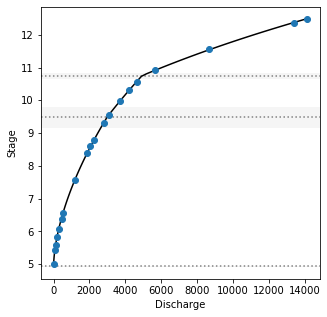

In [40]:
plot_power_law_rating(powerrating,  trace, None)

ADVI typically underestimates uncertainty; NUTS gives better results but will be slower for multiple segments.

In [ ]:
n = 4
with powerrating:
    trace = pm.sample(tune=3000, chains=n, cores=n, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, a, hs_, sigma]


In [ ]:
n = 4
with powerrating:
    trace = pm.sample(tune=2000, chains=n, cores=n, target_accept=0.90)

In [ ]:
plot_power_law_rating(powerrating,  trace, None)

#  Notes
This notebook demonstrates the segmented power law. Sometimes other models may work better.

Thanks to the USGS workflow, we can choose any model $f()$ for fitting a particular rating...

\begin{align}
q = f(\theta,s)
\end{align}
where f is the functional form of the rating: power law, spline, NN, etc.

Rather than use this function directly, USGS discritizes $q$
\begin{align}
d(f(\theta,s)) = \begin{bmatrix} s & \hat q \end{bmatrix}
\end{align}
and the discritized form is saved



1. To develop a rating, select a set of observations ($q_1$,$s_1$) and weights $w_1$, fit a rating model and  discritize to yield $\hat q_1$.

1. At a later point in time, develop a new rating from another (perhaps overlapping) set of observations ($q_2$, $s_2$, $w_2$) and discritize as $\hat q_2$.

1. As we accrue more ratings, we form a matrix $q_{ij}$, where $i$ is the rating and $j$ is the stage index. Flow at a particular time and stage ($t$,$s$) is estimated by interpolating between elements in this matrix.

1. After many ratings, we can apply Greg's approach to compute shift uncertainty at each stage $q_{,j}$.

# Scratch